In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Downloading files...")
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv
# !cp /content/drive/MyDrive/training3.zip /content/

In [ ]:
print("Unzipping files...")
# !unzip -q /content/training3.zip
!unzip -q /content/test.zip
!unzip -q /content/test_partial.zip

Unzipping files...


In [ ]:
import zipfile

zip_file_path = "/content/drive/MyDrive/Real_training3.zip"
extract_path = "/content/"


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed.")


Extraction completed.


In [ ]:
print("Cleaning up...")
# !rm training3.zip
!rm test.zip
!rm test_partial.zip

print("Data ready.")

Cleaning up...
Data ready.


Class 00032: 8058 images
Class 00036: 5331 images
Class 00018: 5758 images
Class 00039: 6616 images
Class 00034: 5889 images
Class 00031: 5235 images
Class 00042: 4304 images
Class 00011: 5214 images
Class 00005: 5448 images
Class 00015: 6707 images
Class 00023: 5399 images
Class 00030: 5007 images
Class 00002: 7136 images
Class 00013: 5701 images
Class 00001: 7426 images
Class 00033: 7932 images
Class 00040: 7961 images
Class 00021: 7203 images
Class 00000: 5681 images
Class 00022: 6670 images
Class 00029: 7285 images
Class 00016: 7734 images
Class 00035: 6238 images
Class 00025: 5401 images
Class 00028: 7860 images
Class 00007: 5258 images
Class 00038: 7768 images
Class 00027: 6805 images
Class 00003: 6843 images
Class 00041: 8099 images
Class 00024: 5114 images
Class 00019: 6690 images
Class 00004: 6386 images
Class 00037: 7090 images
Class 00006: 7855 images
Class 00009: 5669 images
Class 00014: 7936 images
Class 00020: 7184 images
Class 00012: 6346 images
Class 00017: 7833 images


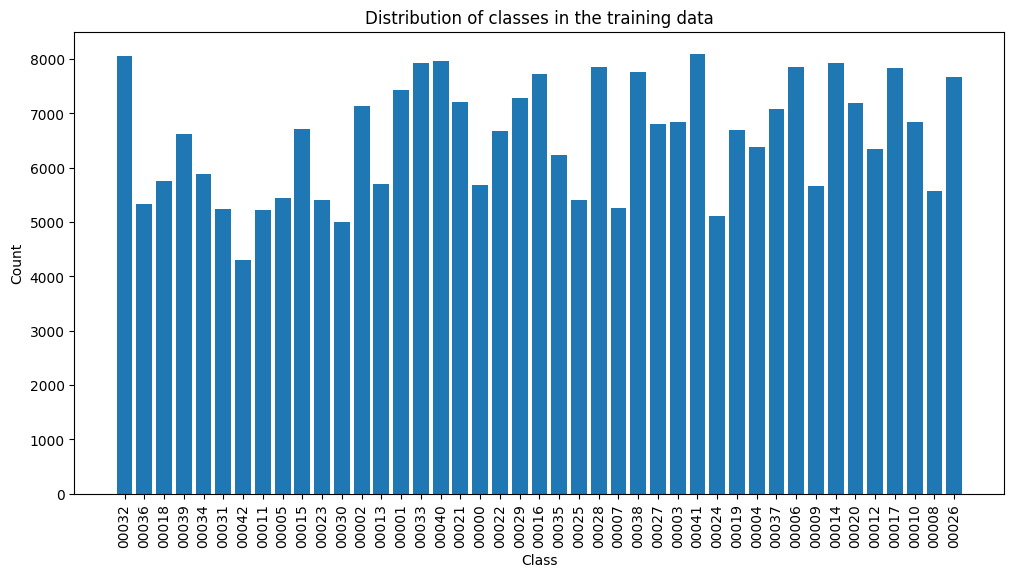

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_class_distribution(directory, title):
    sub_dirs = os.listdir(directory)

    class_counts = {}

    for dir_name in sub_dirs:

        dir_path = os.path.join(directory, dir_name)


        if os.path.isdir(dir_path):
            num_files = len(os.listdir(dir_path))
            class_counts[dir_name] = num_files

            print(f"Class {dir_name}: {num_files} images")

    plt.figure(figsize=(12,6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

train_dir = '/content/training3'
test_dir = '/content/test'
validation_dir = '/content/test_partial'

plot_class_distribution(train_dir, 'Distribution of classes in the training data')

In [ ]:
!pip install tensorflow keras-tuner

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
import os
import glob
from tensorflow.keras.layers import Dropout

def validate_image(img_path):
    try:
        with Image.open(img_path) as img:
            img.verify()  # verify that it is, in fact an image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False

def image_generator(directory, batch_size, image_size, num_classes, validation_split=0.1):
    sub_dirs = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]
    sub_dirs.sort()  # Make sure the directories are in a fixed order
    all_image_files = []
    labels = []
    for i, sub_dir in enumerate(sub_dirs):
        image_files = glob.glob(os.path.join(directory, sub_dir) + '/*.jpg')
        image_files.extend(glob.glob(os.path.join(directory, sub_dir) + '/*.jpeg'))
        all_image_files.extend(image_files)
        labels.extend([i] * len(image_files))

    # Split the data into training and validation sets
    train_image_files, valid_image_files, train_labels, valid_labels = train_test_split(all_image_files, labels, test_size=validation_split, stratify=labels)
    return generate_batches(train_image_files, train_labels, batch_size, image_size, num_classes), generate_batches(valid_image_files, valid_labels, batch_size, image_size, num_classes)

def generate_batches(image_files, labels, batch_size, image_size, num_classes):
    while True:
        # shuffle image files and labels together
        temp = list(zip(image_files, labels))
        np.random.shuffle(temp)
        image_files, labels = zip(*temp)
        # select batch_size number of samples without replacement
        for start in range(0, len(image_files), batch_size):
            end = min(start + batch_size, len(image_files))
            batch_files = image_files[start:end]
            batch_labels = labels[start:end]
            images = []
            batch_labels_categorical = []
            for file, label in zip(batch_files, batch_labels):
                if validate_image(file):
                    try:
                        img = load_img(file, target_size=image_size)
                        img_array = img_to_array(img) / 255.  # normalize pixel values
                        images.append(img_array)
                        batch_labels_categorical.append(label)
                    except Exception as e:
                        print(f"Error: {file}, {e}")
            yield np.array(images), to_categorical(batch_labels_categorical, num_classes=num_classes)

# Set directories and parameters
training_dir = '/content/training3'
image_size = (100, 100)
num_classes = 43
epochs = 20
initial_lr = 0.001
decay = 1 / epochs
batch_size = 512

# Initialize image generator
train_gen, valid_gen = image_generator(training_dir, batch_size, image_size, num_classes, validation_split=0.2)
steps_per_epoch = int(len(glob.glob(training_dir + '/**/*.jpg', recursive=True)) * (1 - 0.2) // batch_size)
validation_steps = int(len(glob.glob(training_dir + '/**/*.jpg', recursive=True)) * 0.2 // batch_size)

# Define the input shape
input_shape = (*image_size, 3)

# Define the model
model_input = Input(shape=input_shape)

base_model1 = DenseNet121(weights='imagenet', include_top=False)(model_input)
x1 = GlobalAveragePooling2D()(base_model1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.5)(x1)  # Add Dropout layer here, 0.5 is the fraction of inputs to drop
predictions1 = Dense(num_classes, activation='softmax')(x1)

base_model2 = ResNet50V2(weights='imagenet', include_top=False)(model_input)
x2 = GlobalAveragePooling2D()(base_model2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.5)(x2)  # Add Dropout layer here, 0.5 is the fraction of inputs to drop
predictions2 = Dense(num_classes, activation='softmax')(x2)

outputs = Average()([predictions1, predictions2])
ensemble_model = Model(inputs=model_input, outputs=outputs)
# Define the learning rate decay
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

# Compile the model
ensemble_model.compile(optimizer=Adam(learning_rate=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
ensemble_model.fit(
    x=train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    epochs=epochs,
    verbose=1,
    callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1), ReduceLROnPlateau(verbose=1)]
)

94668760/94668760 [==============================] - 4s 0us/step

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
440/440 [==============================] - 326s 477ms/step - loss: 0.1669 - accuracy: 0.9611 - val_loss: 0.0669 - val_accuracy: 0.9846 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009523809976166202.
Epoch 2/20
440/440 [==============================] - 204s 445ms/step - loss: 0.0340 - accuracy: 0.9921 - val_loss: 0.3536 - val_accuracy: 0.9082 - lr: 9.5238e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008658009094440124.
Epoch 3/20
440/440 [==============================] - 196s 445ms/step - loss: 0.0133 - accuracy: 0.9966 - val_loss: 0.0149 - val_accuracy: 0.9965 - lr: 8.6580e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007528703376326872.
Epoch 4/20
440/440 [==============================] - 196s 445ms/step - loss: 0.0085 - accuracy: 0.9979 - val_loss: 0.1140 - val_a

In [ ]:

import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score


test_dir = '/content/test'
test_partial_dir = '/content/test_partial'
test_csv_path = '/content/test_classes_partial.csv'


df = pd.read_csv(test_csv_path)
print(df.columns)

test_filenames = sorted(os.listdir(test_dir))
test_partial_filenames = sorted(os.listdir(test_partial_dir))


df_test = df[:200].copy()
df_test_partial = df[:200].copy()
print(len(df_test_partial))
print(len(test_partial_filenames))


df_test['Filename'] = test_filenames[:200]
df_test_partial['Filename'] = test_partial_filenames[:200]


datagen = ImageDataGenerator(rescale=1./255)


def test_model_on_directory(model, directory, dataframe, csv_output_path):
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='Filename',
        y_col='ClassId',
        target_size=image_size,
        class_mode=None,
        batch_size=32,
        shuffle=False,
    )

    probabilities = model.predict(generator)
    predictions = np.argmax(probabilities, axis=1)


    pd.DataFrame(predictions, columns=['predictions']).to_csv(csv_output_path, index=False)

    true_labels = dataframe["ClassId"].values
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy


test_partial_accuracy = test_model_on_directory(ensemble_model, test_partial_dir, df_test_partial, '/content/test_partial_predictions.csv')
test_accuracy = test_model_on_directory(ensemble_model, test_dir, df_test, '/content/test_predictions.csv')


print(f"Accuracy on 'test': {test_accuracy * 100:.2f}%")
print(f"Accuracy on 'test_partial': {test_partial_accuracy * 100:.2f}%")

Index(['Filename', 'ClassId'], dtype='object')
200
201
Found 200 validated image filenames.
7/7 [==============================] - 4s 53ms/step
Found 200 validated image filenames.
7/7 [==============================] - 0s 26ms/step
Accuracy on 'test': 99.00%
Accuracy on 'test_partial': 99.00%


In [ ]:
def predict_on_directory(model, directory, dataframe, csv_output_path):
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='Filename',
        y_col=None,
        target_size=image_size,
        class_mode=None,
        batch_size=32,
        shuffle=False,
    )


    probabilities = model.predict(generator)
    predictions = np.argmax(probabilities, axis=1)

    pd.DataFrame(predictions, columns=['predictions']).to_csv(csv_output_path, index=False)


df_test_all = pd.DataFrame(test_filenames, columns=['Filename'])
predict_on_directory(ensemble_model, test_dir, df_test_all, '/content/predictions-99-5.csv')

Found 12630 validated image filenames.
395/395 [==============================] - 10s 26ms/step


In [ ]:
df_predictions = pd.read_csv('/content/predictions-99-5.csv')
df_true_answers = pd.read_csv('/content/test_classes_partial.csv')

df_predictions = df_predictions.head(len(df_true_answers))

accuracy = accuracy_score(df_true_answers['ClassId'], df_predictions['predictions'])

print(f"Accuracy: {accuracy * 100:.2f}%")

from sklearn.metrics import f1_score

f1 = f1_score(df_true_answers['ClassId'], df_predictions['predictions'], average='weighted')

print(f"F1 Score: {f1 * 100:.2f}%")

Accuracy: 99.00%
F1 Score: 98.89%


In [ ]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet121 (Functional)       (None, None, None,   7037504     ['input_1[0][0]']                
                                1024)                                                             
                                                                                                  
 resnet50v2 (Functional)        (None, None, None,   23564800    ['input_1[0][0]']                
                                2048)                                                         